In [7]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define parameters
year = 2014 # 2014, 2015, 2016, 2017
market_demand = 'high' # 'low', 'moderate', or 'high'

# --- Step 1: Read the full data for the year to get global min/max ---
file_name = '../data/processed/simulations/simulations_apr7.parquet'
df_full_year = pd.read_parquet(file_name)
df_full_year = df_full_year[df_full_year['Year'] == year]

# --- Step 2: Determine global color scale limits for the entire year ---
v_min = df_full_year['Mean Profit Percent Change'].min()
v_max = df_full_year['Mean Profit Percent Change'].max()
print(f"Global Min/Max for {year}: {v_min:.2f}%, {v_max:.2f}%") # Optional: print the range

# --- Step 3: Filter the data for the specific market demand ---
df_profit_all = df_full_year[df_full_year['Market Demand'] == market_demand].copy() # Use .copy() to avoid SettingWithCopyWarning

# Convert 'Quantile' to string type for consistent labeling
df_profit_all['Quantile'] = df_profit_all['Quantile'].astype(str)

# Get sorted unique V6 Percent and Initial Probability values
unique_v6_percent = sorted(df_profit_all['V6 Percent'].unique())
unique_init_prob = sorted(df_profit_all['Initial Probability'].unique())

# **Format initial probabilities without trailing zeros**
def format_prob(prob, decimal_places=5):
    formatted = f"{prob:.{decimal_places}f}".rstrip('0').rstrip('.')
    return formatted if formatted else '0'

unique_init_prob_labels = [format_prob(prob) for prob in unique_init_prob]

# Define the grid size
n_rows = len(unique_v6_percent)
n_cols = len(unique_init_prob)

# Create subplot titles as empty strings
subplot_titles = [''] * (n_rows * n_cols)

# Create the figure with subplots
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=subplot_titles,
    horizontal_spacing=0.02,
    vertical_spacing=0.02,
    shared_xaxes=True,
    shared_yaxes=True,
    specs=[[{'type': 'heatmap'} for _ in range(n_cols)] for _ in range(n_rows)]
)

# --- Step 4: Use a colorblind-friendly colorscale ('Cividis') ---
colorscale_choice = 'Cividis' # Other options: 'Plasma', 'Magma', 'Viridis'

# Add heatmaps to subplots
for _, row_data in df_profit_all[['V6 Percent', 'Initial Probability']].drop_duplicates().iterrows():
    v6_value = row_data['V6 Percent']
    init_prob_value = row_data['Initial Probability']

    # Filter the dataframe for the current combination
    df_filtered = df_profit_all[
        (df_profit_all['V6 Percent'] == v6_value) &
        (df_profit_all['Initial Probability'] == init_prob_value)
    ]

    # Pivot the data for heatmap
    pivot_profit = df_filtered.pivot_table(
        values='Mean Profit Percent Change',
        index='Quantile',
        columns='Sprays in May',
        aggfunc="mean"
    ).sort_index(axis=1) # Sort columns (Sprays in May) numerically if needed

    # Ensure columns are sorted numerically (sometimes pivot might change order)
    pivot_profit = pivot_profit.sort_index(axis=1)

    # Get x and y axes labels
    x_labels = pivot_profit.columns.tolist()
    y_labels = pivot_profit.index.tolist() # Quantiles are already sorted as strings '0', '10', ... '90'

    # Determine subplot position
    v6_index = unique_v6_percent.index(v6_value)
    init_prob_index = unique_init_prob.index(init_prob_value)
    row = v6_index + 1
    col = init_prob_index + 1
    
    # Add heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=pivot_profit.values,
            x=x_labels,
            y=y_labels,
            colorscale=colorscale_choice,
            # --- Step 6: Apply Global Min/Max ---
            zmin=v_min,
            zmax=v_max,
            coloraxis='coloraxis',
            showscale=False,
            xgap=1, # Add small gaps for clarity
            ygap=1,
            hoverongaps=False
        ),
        row=row,
        col=col
    )

# --- Step 5: Set white background and black font ---
plot_bg_color = 'white'
paper_bg_color = 'white'
font_color = 'black'

# Update layout
fig.update_layout(
    template='plotly_white', # Use a white template as a base
    plot_bgcolor=plot_bg_color,
    paper_bgcolor=paper_bg_color,
    font=dict(
        color=font_color,
        size=10
    ),
    title=dict(
        text=f'Relative Change in Profit given {market_demand.capitalize()} Market Demand in {year}',
        font=dict(
            color=font_color, # Updated font color
            size=18
        ),
        x=0.5,
        y=0.98, # Adjust vertical position if needed
        xanchor='center',
        yanchor='top'
    ),
    margin=dict(l=80, r=180, t=120, b=80), # Increased top margin
    # --- Step 6: Apply Global Min/Max to coloraxis ---
    coloraxis=dict(
        colorscale=colorscale_choice, # Ensure coloraxis uses the same scale
        cmin=v_min,
        cmax=v_max,
        colorbar=dict(
            title=dict(
                text='Profit % Change<br>(Entire Year Range)', # Updated title
                side='right',
                font=dict(color=font_color) # Ensure colorbar font is readable
            ),
            tickfont=dict(size=10, color=font_color), # Ensure ticks are readable
            len=1.0, # Adjusted length slightly
            y=0.5,
            x=1.08,
            thickness=15 # Slightly thicker colorbar
        )
    )
)

# Add "Initial Probability of Disease" label at the top center
fig.add_annotation(
    dict(
        text="Initial Probability of Disease",
        x=0.5,
        y=1.15, # Adjusted position slightly higher
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=12,
            color=font_color # Updated font color
        ),
        align='center',
        xanchor='center'
    )
)

# Add initial probability labels
for idx, init_prob_label in enumerate(unique_init_prob_labels):
    x_pos = (idx + 1 - 0.5) / n_cols
    fig.add_annotation(
        dict(
            text=f"p₀ = {init_prob_label}",
            x=x_pos,
            y=1.08, # Adjusted position
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=10, # Slightly larger for readability
                color=font_color # Updated font color
            ),
            align='center',
            xanchor='center'
        )
    )

# Add row labels (% V6) at the right of each row
fig.add_annotation(
        dict(
            text="% V6",
            x=1.08,  # Position label title
            y=1.03,  # Align with p0 labels
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=12,
                color=font_color
            ),
            align='right',
            xanchor='left', # Anchor to the left of the text
            yanchor='middle'
        )
    )
for idx, v6_value in enumerate(unique_v6_percent):
    y_pos = 1 - ((idx + 1 - 0.5) / n_rows)
    fig.add_annotation(
        dict(
            text=f"{int(v6_value * 100)}%",
            x=1.04,
            y=y_pos,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=10, # Slightly larger
                color=font_color # Updated font color
            ),
            align='right',
            xanchor='left', # Anchor to the left of the text
            yanchor='middle'
        )
    )

# Add shared x-axis title
fig.add_annotation(
    dict(
        text="Number of Sprays in May",
        x=0.5,
        y=-0.13, # Adjusted position
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=12,
            color=font_color # Updated font color
        ),
        align='center'
    )
)

# Add shared y-axis title
fig.add_annotation(
    dict(
        text="Percentile of Dispersal-Centrality",
        x=-0.07, # Adjusted position
        y=0.5,
        textangle=-90,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=12,
            color=font_color # Updated font color
        ),
        align='center'
    )
)

# Update hover template
fig.update_traces(
    hovertemplate=
    'Sprays in May: %{x}<br>' +
    'Dispersal Percentile: %{y}<br>' + # Changed label for clarity
    'Profit % Change: %{z:.2f}%<extra></extra>'
)

# Show the figure
fig.show()

# Optional: Save the figure
# fig.write_html(f'profit_heatmap_{year}_{market_demand}_white_cividis_global_scale.html')

Global Min/Max for 2014: -11.34%, 0.37%


In [20]:
v_max

0.36599818443154125

In [19]:
v_min

-11.344691654746143

In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define parameters
year = 2016 # 2014, 2015, 2016, 2017
market_demand = 'low' # 'low', 'moderate', or 'high'

# Read and filter the data
file_name = '../data/processed/simulations/simulations_apr7.parquet'
df_profit_all = pd.read_parquet(file_name)
df_profit_all = df_profit_all[
    (df_profit_all['Year'] == year) & 
    (df_profit_all['Market Demand'] == market_demand)
]

# Convert 'Quantile' to string type for consistent labeling
df_profit_all['Quantile'] = df_profit_all['Quantile'].astype(str)

# Get sorted unique V6 Percent and Initial Probability values
unique_v6_percent = sorted(df_profit_all['V6 Percent'].unique())
unique_init_prob = sorted(df_profit_all['Initial Probability'].unique())

# **Format initial probabilities without trailing zeros**
def format_prob(prob, decimal_places=5):
    formatted = f"{prob:.{decimal_places}f}".rstrip('0').rstrip('.')
    return formatted if formatted else '0'

unique_init_prob_labels = [format_prob(prob) for prob in unique_init_prob]

# Define the grid size
n_rows = len(unique_v6_percent)
n_cols = len(unique_init_prob)

# Create subplot titles as empty strings
subplot_titles = [''] * (n_rows * n_cols)

# Create the figure with subplots
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=subplot_titles,
    horizontal_spacing=0.02,
    vertical_spacing=0.02,
    shared_xaxes=True,
    shared_yaxes=True,
    specs=[[{'type': 'heatmap'} for _ in range(n_cols)] for _ in range(n_rows)]
)

# Determine global color scale limits
v_min = df_profit_all['Mean Profit Percent Change'].min()
v_max = df_profit_all['Mean Profit Percent Change'].max()

# Add heatmaps to subplots
for _, row_data in df_profit_all[['V6 Percent', 'Initial Probability']].drop_duplicates().iterrows():
    v6_value = row_data['V6 Percent']
    init_prob_value = row_data['Initial Probability']

    # Filter the dataframe for the current combination
    df_filtered = df_profit_all[
        (df_profit_all['V6 Percent'] == v6_value) &
        (df_profit_all['Initial Probability'] == init_prob_value)
    ]

    # Pivot the data for heatmap
    pivot_profit = df_filtered.pivot_table(
        values='Mean Profit Percent Change',
        index='Quantile',
        columns='Sprays in May',
        aggfunc="mean"
    ).sort_index(axis=1)

    # Get x and y axes labels
    x_labels = pivot_profit.columns.tolist()
    y_labels = pivot_profit.index.tolist()

    # Determine subplot position
    v6_index = unique_v6_percent.index(v6_value)
    init_prob_index = unique_init_prob.index(init_prob_value)
    row = v6_index + 1
    col = init_prob_index + 1

    # Add heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=pivot_profit.values,
            x=x_labels,
            y=y_labels,
            colorscale='Viridis',
            zmin=v_min,
            zmax=v_max,
            coloraxis='coloraxis',
            showscale=False,
            xgap=0,
            ygap=0,
            hoverongaps=False
        ),
        row=row,
        col=col
    )

# Define Dracula color palette
dracula_bg = '#282a36'
dracula_font = '#f8f8f2'

# Update layout
fig.update_layout(
    template=None,
    plot_bgcolor=dracula_bg,
    paper_bgcolor=dracula_bg,
    font=dict(
        color=dracula_font,
        size=10
    ),
    title=dict(
        text=f'Relative Change in Profit given {market_demand.capitalize()} Market Demand in {year}',
        font=dict(
            color=dracula_font,
            size=18
        ),
        x=0.5,
        y=0.96,
        xanchor='center',
        yanchor='top'
    ),
    margin=dict(l=80, r=180, t=100, b=80),  # Increased top margin to accommodate new label
    coloraxis=dict(
        colorscale='Viridis',
        cmin=v_min,
        cmax=v_max,
        colorbar=dict(
            title=dict(
                text='Profit % Change',
                side='right'
            ),
            tickfont=dict(size=10),
            len=1.05,
            y=0.5,
            x=1.08,
            thickness=10
        )
    )
)

# Add "Initial Probability of Disease" label at the top center
fig.add_annotation(
    dict(
        text="Initial Probability of Disease",
        x=0.5,
        y=1.15,  # Positioned slightly above the p₀ labels
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=12,  # Adjust font size as needed
            color=dracula_font
        ),
        align='center',
        xanchor='center'
    )
)

# Add initial probability labels with decimal notation without trailing zeros
for idx, init_prob_label in enumerate(unique_init_prob_labels):
    x_pos = (idx + 1 - 0.5) / n_cols  # Centered above each column
    fig.add_annotation(
        dict(
            text=f"p₀ = {init_prob_label}",
            x=x_pos,
            y=1.06,  # Positioned below the new "Initial Probability of Disease" label
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=8,  # Adjust font size as needed
                color=dracula_font
            ),
            align='center',
            xanchor='center'
        )
    )

# Add row labels (% V6) at the right of each row
for idx, v6_value in enumerate(unique_v6_percent):
    y_pos = 1 - ((idx + 1 - 0.5) / n_rows)
    fig.add_annotation(
        dict(
            text=f"{int(v6_value * 100)}% V6",
            x=1.08,
            y=y_pos,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=8,
                color=dracula_font
            ),
            align='center',
            yanchor='middle'
        )
    )

# Add shared x-axis title
fig.add_annotation(
    dict(
        text="Number of Sprays in May",
        x=0.5,
        y=-0.15,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=12,
            color=dracula_font
        ),
        align='center'
    )
)

# Add shared y-axis title
fig.add_annotation(
    dict(
        text="Percentile of Dispersal-Centrality",
        x=-0.08,
        y=0.5,
        textangle=-90,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=12,
            color=dracula_font
        ),
        align='center'
    )
)

# Update hover template
fig.update_traces(
    hovertemplate=
    'Sprays in May: %{x}<br>' +
    'Percentile: %{y}<br>' +
    'Profit % Change: %{z:.2f}%<extra></extra>'
)

# Show the figure
fig.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the list of years and market demands to loop over
years = [2014, 2015, 2016, 2017]
market_demands = ['low', 'moderate', 'high']

# Read the data file once
file_name = '../data/processed/simulations/simulations_apr7.parquet'
df_all = pd.read_parquet(file_name)

# Loop over each year and market demand combination
for year in years:
    for market_demand in market_demands:
        # Filter the data for the current year and market demand
        df_profit = df_all[(df_all['Year'] == year) & 
                           (df_all['Market Demand'] == market_demand)].copy()
        
        # Check if there's data for this combination
        if df_profit.empty:
            print(f"No data for Year {year} and Market Demand {market_demand}")
            continue

        # Convert 'Quantile' to string for consistent labeling
        df_profit['Quantile'] = df_profit['Quantile'].astype(str)

        # Get sorted unique values for V6 Percent and Initial Probability
        unique_v6_percent = sorted(df_profit['V6 Percent'].unique())
        unique_init_prob = sorted(df_profit['Initial Probability'].unique())

        # Function to format initial probabilities without trailing zeros
        def format_prob(prob, decimal_places=5):
            formatted = f"{prob:.{decimal_places}f}".rstrip('0').rstrip('.')
            return formatted if formatted else '0'

        unique_init_prob_labels = [format_prob(prob) for prob in unique_init_prob]

        # Define the grid size for subplots
        n_rows = len(unique_v6_percent)
        n_cols = len(unique_init_prob)
        subplot_titles = [''] * (n_rows * n_cols)

        # Create the subplot figure
        fig = make_subplots(
            rows=n_rows, cols=n_cols,
            subplot_titles=subplot_titles,
            horizontal_spacing=0.02,
            vertical_spacing=0.02,
            shared_xaxes=True,
            shared_yaxes=True,
            specs=[[{'type': 'heatmap'} for _ in range(n_cols)] for _ in range(n_rows)]
        )

        # Determine global color scale limits
        v_min = df_profit['Mean Profit Percent Change'].min()
        v_max = df_profit['Mean Profit Percent Change'].max()

        # Add heatmaps for each unique combination of V6 Percent and Initial Probability
        for _, row_data in df_profit[['V6 Percent', 'Initial Probability']].drop_duplicates().iterrows():
            v6_value = row_data['V6 Percent']
            init_prob_value = row_data['Initial Probability']

            # Filter the dataframe for the current combination
            df_filtered = df_profit[(df_profit['V6 Percent'] == v6_value) &
                                    (df_profit['Initial Probability'] == init_prob_value)]

            # Pivot the data to create the heatmap matrix
            pivot_profit = df_filtered.pivot_table(
                values='Mean Profit Percent Change',
                index='Quantile',
                columns='Sprays in May',
                aggfunc="mean"
            ).sort_index(axis=1)

            # Get x and y labels
            x_labels = pivot_profit.columns.tolist()
            y_labels = pivot_profit.index.tolist()

            # Determine subplot row and column positions
            v6_index = unique_v6_percent.index(v6_value)
            init_prob_index = unique_init_prob.index(init_prob_value)
            row = v6_index + 1
            col = init_prob_index + 1

            # Add the heatmap trace to the subplot
            fig.add_trace(
                go.Heatmap(
                    z=pivot_profit.values,
                    x=x_labels,
                    y=y_labels,
                    colorscale='Viridis',
                    zmin=v_min,
                    zmax=v_max,
                    coloraxis='coloraxis',
                    showscale=False,
                    xgap=0,
                    ygap=0,
                    hoverongaps=False
                ),
                row=row,
                col=col
            )

        # Define Dracula color palette
        dracula_bg = '#282a36'
        dracula_font = '#f8f8f2'

        # Update the figure layout and add title (with dynamic market demand and year)
        fig.update_layout(
    template=None,
    plot_bgcolor=dracula_bg,
    paper_bgcolor=dracula_bg,
    font=dict(
        color=dracula_font,
        size=10
    ),
    title=dict(
        text=f'Relative Change in Profit given {market_demand.capitalize()} Market Demand in {year}',
        font=dict(
            color=dracula_font,
            size=18
        ),
        x=0.5,
        y=0.96,
        xanchor='center',
        yanchor='top'
    ),
    margin=dict(l=80, r=180, t=100, b=80),
    coloraxis=dict(
        colorscale='Viridis',
        cmin=v_min,
        cmax=v_max,
        colorbar=dict(
            title='Profit % Change',
            tickfont=dict(size=10),
            len=1.05,
            y=0.5,
            x=1.08,
            thickness=10
        )
    )
)



        # Update hover template for all traces
        fig.update_traces(
            hovertemplate=
            'Sprays in May: %{x}<br>' +
            'Percentile: %{y}<br>' +
            'Profit % Change: %{z:.2f}%<extra></extra>'
        )

        # Save the figure to a file (PNG format)
        output_filename = f'graph_{year}_{market_demand}.png'
        fig.write_image(output_filename)
        print(f"Saved graph for Year {year} and Market Demand {market_demand} as {output_filename}")

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Read and filter the data
file_name = '../data/processed/simulations/simulations.csv'
df_profit_all = pd.read_csv(file_name)

# Define parameters
year = 2014
market_demand = 'high'

# Filter data
df_profit_all = df_profit_all[
    (df_profit_all['Year'] == year) & 
    (df_profit_all['Market Demand'] == market_demand)
]

# Convert columns to appropriate types and create labels
df_profit_all['Quantile'] = df_profit_all['Quantile'].astype(str)
df_profit_all['V6_percent_label'] = (df_profit_all['V6 Percent'] * 100).astype(int).astype(str) + '% V6'
df_profit_all['initial_prob_label'] = 'p₀=' + df_profit_all['Initial Probability'].map('{:.1e}'.format)

# Get unique values and labels
unique_v6_percent = sorted(df_profit_all['V6 Percent'].unique())
unique_v6_labels = [f"{int(v6 * 100)}% V6" for v6 in unique_v6_percent]

unique_init_prob = sorted(df_profit_all['Initial Probability'].unique())
unique_init_prob_labels = [f"p₀={prob:.1e}" for prob in unique_init_prob]

# Define grid dimensions
n_rows = len(unique_v6_percent)
n_cols = len(unique_init_prob)

# Create subplot titles
subplot_titles = [''] * (n_rows * n_cols)

# Create figure with subplots
fig = make_subplots(
    rows=n_rows, 
    cols=n_cols,
    subplot_titles=subplot_titles,
    horizontal_spacing=0.05,
    vertical_spacing=0.05,
    shared_xaxes=True,
    shared_yaxes=True,
    specs=[[{'type': 'heatmap'} for _ in range(n_cols)] for _ in range(n_rows)]
)

# Get unique combinations
unique_combinations = df_profit_all[
    ['V6 Percent', 'V6_percent_label', 'Initial Probability', 'initial_prob_label']
].drop_duplicates()
unique_combinations = unique_combinations.sort_values(
    ['V6 Percent', 'Initial Probability'], 
    ascending=[True, True]
)

# Calculate global color scale limits
v_min = df_profit_all['Mean Profit Percent Change'].min()
v_max = df_profit_all['Mean Profit Percent Change'].max()

# Add heatmaps to subplots
for _, row_data in unique_combinations.iterrows():
    # Get labels and values
    v6_label = row_data['V6_percent_label']
    init_prob_label = row_data['initial_prob_label']
    v6_value = row_data['V6 Percent']

    # Filter data
    df_filtered = df_profit_all[
        (df_profit_all['V6_percent_label'] == v6_label) &
        (df_profit_all['initial_prob_label'] == init_prob_label)
    ]

    # Create pivot table
    pivot_profit = df_filtered.pivot_table(
        values='Mean Profit Percent Change',
        index='Quantile',
        columns='Sprays in May',
        aggfunc='mean'
    ).sort_index(axis=1)

    # Get axis labels
    x_labels = pivot_profit.columns.tolist()
    y_labels = pivot_profit.index.tolist()

    # Calculate subplot position
    v6_index = unique_v6_percent.index(v6_value)
    init_prob_index = unique_init_prob.index(row_data['Initial Probability'])
    row = v6_index + 1
    col = init_prob_index + 1

    # Add heatmap trace
    fig.add_trace(
        go.Heatmap(
            z=pivot_profit.values,
            x=x_labels,
            y=y_labels,
            colorscale='Viridis',
            zmin=v_min,
            zmax=v_max,
            coloraxis='coloraxis',
            showscale=False,
            xgap=0,
            ygap=0,
            hoverongaps=False
        ),
        row=row,
        col=col
    )

# Define color scheme
dracula_bg = '#282a36'
dracula_font = '#f8f8f2'

# Update layout
fig.update_layout(
    template=None,
    plot_bgcolor=dracula_bg,
    paper_bgcolor=dracula_bg,
    font=dict(
        color=dracula_font,
        size=10
    ),
    title=dict(
        text=f'Figure 2: Relative Change in Profit given {market_demand} Market Demand in {year}',
        font=dict(
            color=dracula_font,
            size=18
        ),
        x=0.45,
        y=0.96,
        xanchor='center',
        yanchor='top'
    ),
    margin=dict(
        l=80,
        r=180,
        t=120,
        b=80
    ),
    coloraxis=dict(
        colorscale='Viridis',
        cmin=v_min,
        cmax=v_max,
        colorbar=dict(
            title='Profit % Change',
            titleside='right',
            tickfont=dict(size=10),
            len=1.05,
            y=0.5,
            x=1.08,
            thickness=10
        )
    )
)

# Add column labels (Initial Probability)
for idx, init_prob_label in enumerate(unique_init_prob_labels):
    x_pos = (idx + 1 - 0.5) / n_cols
    fig.add_annotation(
        dict(
            text=init_prob_label,
            x=x_pos,
            y=1.12,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=10,
                color=dracula_font
            ),
            align='center'
        )
    )

# Add row labels (V6 Percentage)
for idx, v6_label in enumerate(unique_v6_labels):
    y_pos = 1 - ((idx + 1 - 0.5) / n_rows)
    fig.add_annotation(
        dict(
            text=v6_label,
            x=1.12,
            y=y_pos,
            textangle=0,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=10,
                color=dracula_font
            ),
            align='center'
        )
    )

# Add axis titles
fig.add_annotation(
    dict(
        text="Number of Sprays in May",
        x=0.5,
        y=-0.15,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=14,
            color=dracula_font
        ),
        align='center'
    )
)

fig.add_annotation(
    dict(
        text="Percentile of Dispersal-Centrality",
        x=-0.08,
        y=0.5,
        textangle=-90,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=14,
            color=dracula_font
        ),
        align='center'
    )
)

# Update hover template
fig.update_traces(
    hovertemplate=
    'Sprays in May: %{x}<br>' +
    'Percentile: %{y}<br>' +
    'Profit % Change: %{z:.2f}%<extra></extra>'
)

# Show figure
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/simulations/simulations.csv'

In [10]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define parameters
year = 2014
market_demand = 'high'

# Read the data
file_name = '../data/processed/simulations/percent_change/profit_percent_change_simulations_power.csv'
df_profit_all = pd.read_csv(file_name)

# Filter the dataframe
df_profit_all = df_profit_all[
    (df_profit_all['year'] == year) & 
    (df_profit_all['market_demand'] == market_demand)
]

# Convert 'decile' to string type for consistent labeling
df_profit_all['decile'] = df_profit_all['decile'].astype(str)

# Get unique combinations of 'V6_percent' and 'initial_prob'
unique_combinations = df_profit_all[['V6_percent', 'initial_prob']].drop_duplicates().sort_values(['V6_percent', 'initial_prob'])

# Number of unique combinations
num_plots = unique_combinations.shape[0]

# Ensure that the number of plots does not exceed 25 (for a 5x5 grid)
if num_plots > 25:
    raise ValueError(f"Number of unique combinations ({num_plots}) exceeds the 5x5 grid size (25).")

# Define the grid size
n_rows, n_cols = 5, 5

# Create subplot titles for better identification
subplot_titles = [
    f"{int(v6_percent*100)}% V6<br>Prob: {initial_prob:.2e}"
    for v6_percent, initial_prob in unique_combinations.values
]

# Create the figure with subplots
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=subplot_titles,
    horizontal_spacing=0.02,  # Minimal horizontal space between plots
    vertical_spacing=0.02,    # Minimal vertical space between plots
    shared_xaxes=True,        # Share x-axes to minimize space
    shared_yaxes=True,        # Share y-axes to minimize space
    specs=[[{'type': 'heatmap'} for _ in range(n_cols)] for _ in range(n_rows)]
)

# Determine global color scale limits
v_min = df_profit_all['profit_percent_change'].min()
v_max = df_profit_all['profit_percent_change'].max()

for i, (v6_percent, initial_prob) in enumerate(unique_combinations.values):
    # Filter the dataframe for the current combination
    df_filtered = df_profit_all[
        (df_profit_all['V6_percent'] == v6_percent) &
        (df_profit_all['initial_prob'] == initial_prob)
    ]
    
    # Pivot the data for heatmap
    pivot_profit = df_filtered.pivot_table(
        values='profit_percent_change',
        index='decile',
        columns='sprays_in_May',
        aggfunc="mean"
    )
    
    # Sort the columns
    pivot_profit = pivot_profit.sort_index(axis=1)
    
    # Get x and y axes labels
    x_labels = pivot_profit.columns.tolist()
    y_labels = pivot_profit.index.tolist()
    
    # Add heatmap to the subplot
    heatmap = go.Heatmap(
        z=pivot_profit.values,
        x=x_labels,
        y=y_labels,
        colorscale='Viridis',
        zmin=v_min,
        zmax=v_max,
        showscale=True,       # Enable individual color scales
        colorbar=dict(
            title='Profit % Change',
            titleside='right',
            tickfont=dict(size=8),
            lenmode='fraction',
            len=0.6,          # Adjusted to fit within subplot
            y=0.5,
            x=1.1             # Positioning the colorbar outside the heatmap
        ),
        xgap=2,               # Gap between cells in x-direction
        ygap=2,               # Gap between cells in y-direction
        hoverongaps=False
    )
    
    # Determine subplot row and column
    row = (i // n_cols) + 1
    col = (i % n_cols) + 1
    
    fig.add_trace(heatmap, row=row, col=col)

# Define Dracula color palette
dracula_bg = '#282a36'          # Background
dracula_grid = '#44475a'        # Grid lines
dracula_font = '#f8f8f2'        # Default font color
dracula_colorbar_bg = '#282a36' # Colorbar background

# Update layout for Dracula theme
fig.update_layout(
    template=None,  # Remove any existing template
    plot_bgcolor=dracula_bg,
    paper_bgcolor=dracula_bg,
    font=dict(
        color=dracula_font,
        size=10
    ),
    title=dict(
        font=dict(
            color=dracula_font,
            size=18
        )
    ),
    margin=dict(l=40, r=220, t=60, b=40),  # Increased right margin for colorbars
)

# Update x and y axes grid lines and background
for axis in fig['layout']:
    if 'xaxis' in axis or 'yaxis' in axis:
        fig.update_layout(**{
            axis: dict(
                showgrid=True,
                gridcolor=dracula_grid,
                zeroline=False,
                showline=True,
                linecolor=dracula_grid,
                ticks='outside',
                tickfont=dict(color=dracula_font, size=8)
            )
            for axis in fig['layout'] if axis.startswith(('xaxis', 'yaxis'))
        })

# Update layout with optimized size
fig.update_layout(
    height=1200,  # Height in pixels
    width=1200,   # Width in pixels
)

# Update x and y axes to show labels only on the outer plots
for i in range(1, n_rows + 1):
    for j in range(1, n_cols + 1):
        if i < n_rows:
            fig.update_xaxes(showticklabels=False, row=i, col=j)
        if j > 1:
            fig.update_yaxes(showticklabels=False, row=i, col=j)

# Add shared x and y axis titles
fig.add_annotation(
    dict(
        text="Number of Sprays in May",
        x=0.5,
        y=0.04,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=12,
            color=dracula_font
        )
    )
)

fig.add_annotation(
    dict(
        text="Decile of Distance-based Centrality",
        x=0.02,
        y=0.5,
        textangle=-90,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=12,
            color=dracula_font
        )
    )
)

# Final layout adjustments
fig.update_layout(
    title=dict(
        text=f'Profit Percent Change Heatmaps for Year {year} and Market Demand "{market_demand}"',
        x=0.5,
        y=0.95,
        xanchor='center',
        yanchor='top',
        font=dict(
            color=dracula_font,
            size=18
        )
    )
)

# Show the figure
fig.show()


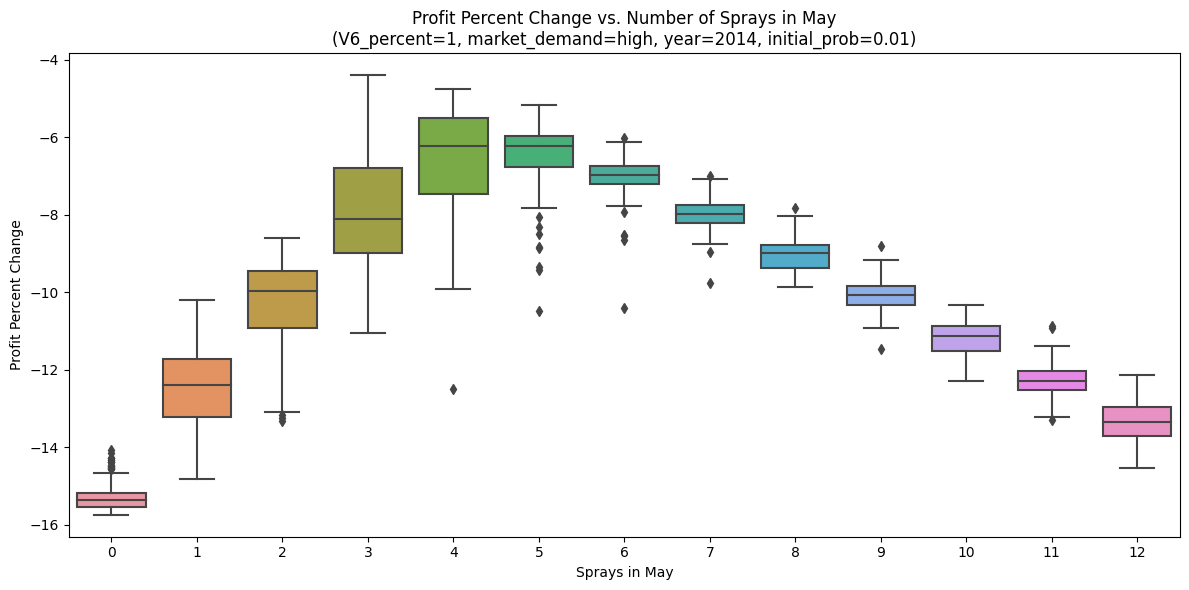

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Ensure the output directory exists
os.makedirs('../reports/figures', exist_ok=True)

# Read the single file
file_name = '../data/processed/simulations/percent_change/profit_percent_change_simulations_power.csv'
df_profit_all = pd.read_csv(file_name)

# Convert 'decile' to string type
df_profit_all['decile'] = df_profit_all['decile'].astype(str)

for year in [2014, 2015, 2016, 2017]:
    for market_demand in ['low', 'moderate', 'high']:
        # Filter the dataframe for the current year and market demand
        df_filtered = df_profit_all[(df_profit_all['year'] == year) & (df_profit_all['market_demand'] == market_demand)]
        
        if df_filtered.empty:
            print(f"No data for year {year} and market demand {market_demand}")
            continue
        
        v_min = df_filtered['profit_percent_change'].min()
        v_max = df_filtered['profit_percent_change'].max()

        # Create a grid of subplots
        fig, axes = plt.subplots(5, 4, figsize=(20, 25))  # Adjust the size as needed

        # Unique combinations of 'V6_percent' and 'initial_prob'
        unique_combinations = df_filtered[['V6_percent', 'initial_prob']].drop_duplicates()

        # Iterate over the unique combinations and plot heatmaps
        for i, (v6_percent, initial_prob) in enumerate(unique_combinations.values):
            # Filter the dataframe for the current combination
            df_subset = df_filtered[(df_filtered['V6_percent'] == v6_percent) & (df_filtered['initial_prob'] == initial_prob)]
            
            # Pivot the data for heatmap
            pivot_profit = df_subset.pivot_table(values='profit_percent_change', index='decile', columns='sprays_in_May', aggfunc="mean")
            
            # Convert column names to integers and sort in ascending order
            pivot_profit.columns = pivot_profit.columns.astype(int)
            pivot_profit = pivot_profit.reindex(sorted(pivot_profit.columns), axis=1)
            
            # Calculate row and column indices for the subplot grid
            row, col = i // 4, i % 4
            
            # Create heatmap
            ax = sns.heatmap(pivot_profit, cmap="YlGnBu", annot=False, fmt=".2f", cbar=True, ax=axes[row][col], vmin=v_min, vmax=v_max)
            
            # Set title and labels
            ax.set_title(f"{int(v6_percent*100)}% V6 - init_prob {initial_prob:.4f}")
            ax.set_xlabel('Number of Sprays in May')
            ax.set_ylabel('Decile of Distance-based Centrality')

        plt.tight_layout()
        
        # Set the main title for the entire figure
        fig.suptitle(f"Profit Percent Change - Year: {year}, Market Demand: {market_demand}", fontsize=16)
        
        # Adjust layout to prevent title overlap
        plt.subplots_adjust(top=0.95)
        
        # Save the figure
        filename = f'../reports/figures/profit_change_heatmap_{year}_{market_demand}.png'
        plt.savefig(filename)
        plt.close()  # Close the figure to free up memory

        print(f"Saved figure: {filename}")

print("All figures have been generated and saved.")

KeyboardInterrupt: 

In [2]:
import numpy as np

theta_may_jun = np.load('../reports/parameters/theta_may-jun_SLSQP_power.npy', allow_pickle=True)
theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_SLSQP_power.npy', allow_pickle=True)

In [3]:
theta_may_jun

array([[-2.35778485e+00],
       [-4.13470989e+00],
       [ 1.58660189e+03],
       [ 1.19894366e+02],
       [ 2.00417911e+03],
       [ 1.01924705e+02],
       [ 1.12904621e+00],
       [ 2.57172574e+00],
       [ 3.14703924e+00],
       [ 1.62234492e+00],
       [ 1.38938059e+01],
       [ 1.00000000e-05]])

# Damage functions and demand

In [4]:

import pandas as pd
import numpy as np
import scipy.stats as stats

# import curve_fit from scipy
from scipy.optimize import curve_fit

# REVENUE FUNCTION

# Data for the estimation of cone incidence vs leaf incidence
df_cone_incidence_leaf_incidence = pd.read_csv('../data/raw/economics/Leaf incidence_vs_Cone_incidence.csv', encoding='utf-8')

# Data preprocessing
df_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.dropna()

# Data for the estimation of yield loss vs cone incidence (change in quantity metric)
df_yield_loss_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
df_yield_loss_cone_incidence = df_yield_loss_cone_incidence[['Cone incidence', 'Yield Loss']]

# Data for the estimation of cone color vs cone incidence (change in quality metric)
df_cone_color_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
df_cone_color_cone_incidence = df_cone_color_cone_incidence[['Cone incidence', 'Cone Color']]


# Data
data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()
data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()
data_cone_color_cone_incidence = df_cone_color_cone_incidence.to_numpy()

# Regressions

# CONE INCIDENCE VS LEAF INCIDENCE
a1, b1 = np.polyfit(data_cone_incidence_leaf_incidence[:, 0], data_cone_incidence_leaf_incidence[:, 1], 1)

# YIELD LOSS VS CONE INCIDENCE
a2, b2 = np.polyfit(data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1], 1)

# CONE COLOR VS CONE INCIDENCE
# Define the exponential decay function that passes through (0, 10)
def exp_decreasing(x, a3, b3):
    return 10 + a3 * (1 - np.exp(-b3 * x))

# Provide an initial guess for the parameters
initial_guess = [1, 1]

# Fit the exponential decay model to the data, with an increased max number of function evaluations
params, _ = curve_fit(exp_decreasing, data_cone_color_cone_incidence[:, 0], data_cone_color_cone_incidence[:, 1], p0=initial_guess, maxfev=5000)

a3, b3 = params


# Load parameters
checkpoint1 = np.load('../reports/checkpoint_high_demand.npy', allow_pickle=True)
theta_high = checkpoint1[0]

checkpoint2 = np.load('../reports/checkpoint_moderate_demand.npy', allow_pickle=True)
theta_moderate = checkpoint2[0]

checkpoint3 = np.load('../reports/checkpoint_low_demand.npy', allow_pickle=True)
theta_low = checkpoint3[0]

# Define logistic sigmoid function
def sigmoid(z):

    g = 1 / (1 + np.exp(-z))
    
    return g

def leaf_incidence_function(plant_incidence, n_leaves=100, D=1.19):
        
        plant_incidence = plant_incidence - 1e-10 # to avoid identity problem
        
        # n_leaves is the number of leaves sampled and D is the index of dispersion
        n_D = n_leaves / D
        
        leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
        
        return leaf_incidence

# QUALITY METRIC
# Function to estimate cone color given plant incidence
def cone_color(plant_incidence):
    
    leaf_incidence = leaf_incidence_function(plant_incidence)
    
    cone_incidence = a1 * leaf_incidence + b1
    
    # intercept fixed at 10 since that's the highest cone color rating
    cone_color = 10 + a3 * (1 - np.exp(-b3 * cone_incidence))
    
    return cone_color

# QUANTITY METRIC
# Function to estimate yield loss given plant incidence (probability of disease in plants)
def yield_loss(plant_incidence):
    
    leaf_incidence = leaf_incidence_function(plant_incidence)
    
    cone_incidence = a1 * leaf_incidence + b1
    
    yield_loss = a2 * cone_incidence
    
    return yield_loss


# Yield in pounds per acre for different varieties
nugget_yield = 2038.0
chinook_yield = 1629.3333
simcoe_yield = 1752.0
mosaic_yield = 2134.0

# Convert yield to pounds per hectare
nugget_yield = nugget_yield * 2.471053814671653
chinook_yield = chinook_yield * 2.471053814671653
simcoe_yield = simcoe_yield * 2.471053814671653
mosaic_yield = mosaic_yield * 2.471053814671653

# PPI (Jan 2022 base) for 2014-2022
ppi = [89.63222295, 78.91586143, 71.31375327, 73.47443209, 73.05062119, 73.34955924, 71.70729197, 89.92332807, 107.9811162]
ppi_2020 = ppi[6]
ppi_2021 = ppi[7]
ppi_2022 = ppi[8]

# Function to estimate revenue and revenue change given plant incidence
def revenue(plant_incidence, variety, demand):
    
    # Define the data for different varieties
    varieties_data = {
        "nugget": {"initial_yield": nugget_yield, "initial_price": np.array([2.5, 4.25, 6.0]) / ppi_2021 * 100},
        "chinook": {"initial_yield": chinook_yield, "initial_price": np.array([4.0, 5.0, 6.5]) / ppi_2021 * 100},
        "simcoe": {"initial_yield": simcoe_yield, "initial_price": np.array([5.0, 6.5, 8.0]) / ppi_2021 * 100},
        "mosaic": {"initial_yield": mosaic_yield, "initial_price": np.array([5.0, 6.5, 8.0]) / ppi_2021 * 100},
    }
    
    demand_to_idx = {
    "low": 0,
    "moderate": 1,
    "high": 2
    }
    
    theta_values = {
        "low": theta_low,
        "moderate": theta_moderate,
        "high": theta_high
    }
    
    # Convert the demand to theta values
    theta_demand = theta_values[demand]
    
    # Extract initial values based on variety
    initial_yields = np.array([varieties_data[var[0]]["initial_yield"] for var in variety])
    initial_prices = np.array([varieties_data[var[0]]["initial_price"][demand_to_idx[demand]] for var in variety])

    # Calculate adjusted yields and prices
    adjusted_yields = initial_yields * (1 - yield_loss(plant_incidence).squeeze())
    adjusted_prices = initial_prices * sigmoid(theta_demand[0] + theta_demand[1] * cone_color(plant_incidence).squeeze())
    
    # Calculate the adjusted revenue
    adjusted_revenues = adjusted_prices * adjusted_yields

    return adjusted_revenues.reshape(-1, 1)


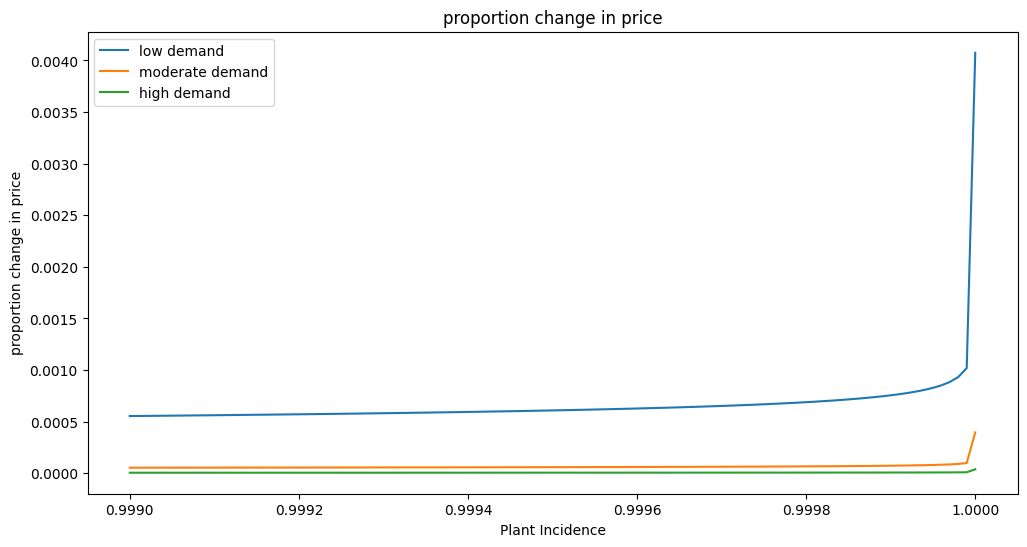

In [9]:
# plot plant_incidence vs
plant_incidence = np.linspace(0.999, 1, 100)


demand_to_idx = {
"low": 0,
"moderate": 1,
"high": 2
}

theta_values = {
    "low": theta_low,
    "moderate": theta_moderate,
    "high": theta_high
}

# Convert the demand to theta values
#theta_demand = theta_values[demand]

#sigmoid(theta_demand[0] + theta_demand[1] * cone_color(plant_incidence))
        

# plot sigmoid function for ['low', 'moderate', 'high'] demand
plt.figure(figsize=(12, 6))
plt.plot(plant_incidence, 1-sigmoid(theta_values['low'][0] + theta_values['low'][1] * cone_color(plant_incidence)), label='low demand')
plt.plot(plant_incidence, 1-sigmoid(theta_values['moderate'][0] + theta_values['moderate'][1] * cone_color(plant_incidence)), label='moderate demand')
plt.plot(plant_incidence, 1-sigmoid(theta_values['high'][0] + theta_values['high'][1] * cone_color(plant_incidence)), label='high demand')
plt.xlabel('Plant Incidence')
plt.ylabel('proportion change in price')
plt.title('proportion change in price')
plt.legend()
plt.show()




In [2]:
import numpy as np

theta_may_jun = np.load('../reports/parameters/theta_may-jun_SLSQP_power.npy', allow_pickle=True)
print(theta_may_jun)

theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_SLSQP_power.npy', allow_pickle=True)
#print(theta_jun_jul)

[[-2.35778485e+00]
 [-4.13470989e+00]
 [ 1.58660189e+03]
 [ 1.19894366e+02]
 [ 2.00417911e+03]
 [ 1.01924705e+02]
 [ 1.12904621e+00]
 [ 2.57172574e+00]
 [ 3.14703924e+00]
 [ 1.62234492e+00]
 [ 1.38938059e+01]
 [ 1.00000000e-05]]


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

landscape_diseased = np.random.binomial(400, 0.0001, size=(100, 1))
number = np.sum(landscape_diseased) / 40000
print("{:10f}".format(number))

  0.000050


In [ ]:
quartiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

  0.049969


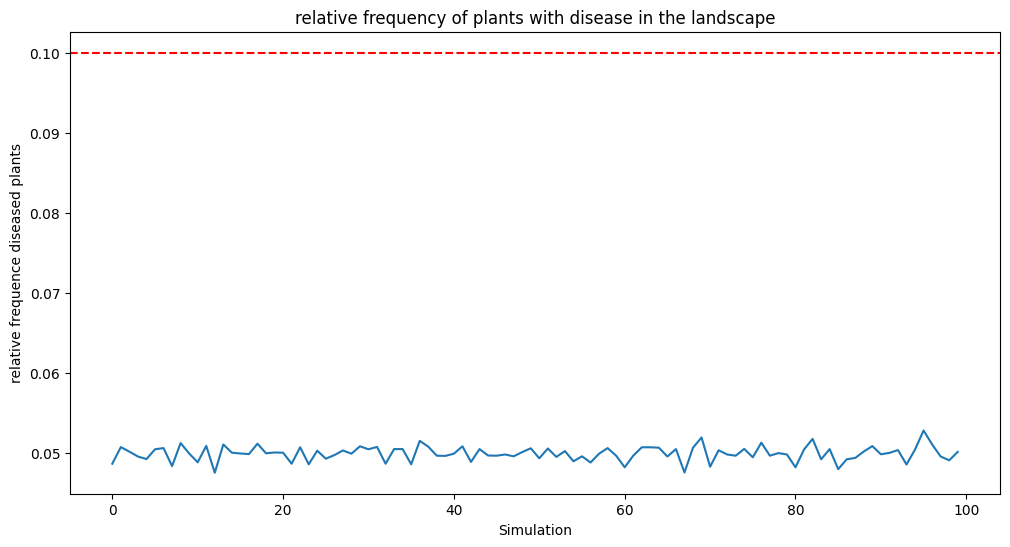

In [125]:
where_prob_zero = np.where(np.array(prob_sim_list) == 0)

y_0_list[where_prob_zero[0][0]]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define parameters
year = 2014
market_demand = 'high'

# Read and filter the data
file_name = '../data/processed/simulations/percent_change/profit_percent_change_simulations_power.csv'
df_profit_all = pd.read_csv(file_name)
df_profit_all = df_profit_all[
    (df_profit_all['year'] == year) & 
    (df_profit_all['market_demand'] == market_demand)
]

# Convert 'decile' to string type for consistent labeling
df_profit_all['decile'] = df_profit_all['decile'].astype(str)

# Rename 'V6_percent' to 'X% V6'
df_profit_all['V6_percent_label'] = (df_profit_all['V6_percent'] * 100).astype(int).astype(str) + '% V6'

# Rename 'initial_prob' to 'init_prob = XXXX'
df_profit_all['initial_prob_label'] = 'init_prob = ' + df_profit_all['initial_prob'].astype(str)

# Get sorted unique V6_percent and initial_prob values
unique_v6_percent = sorted(df_profit_all['V6_percent'].unique())
unique_v6_labels = [f"{int(v6 * 100)}% V6" for v6 in unique_v6_percent]

unique_init_prob = sorted(df_profit_all['initial_prob'].unique())
unique_init_prob_labels = [f"init_prob = {prob}" for prob in unique_init_prob]

# Define the grid size based on unique V6_percent and initial_prob
n_rows = len(unique_v6_percent)       # Number of unique V6_percent labels
n_cols = len(unique_init_prob)        # Number of unique initial_prob labels

# Get unique combinations sorted by V6_percent ascendingly and initial_prob ascendingly
# **Change Made:** Included 'initial_prob' in unique_combinations to prevent KeyError
unique_combinations = df_profit_all[['V6_percent', 'V6_percent_label', 'initial_prob', 'initial_prob_label']].drop_duplicates()
unique_combinations = unique_combinations.sort_values(['V6_percent', 'initial_prob_label'], ascending=[True, True])

# Number of unique combinations
num_plots = unique_combinations.shape[0]

# Create subplot titles as empty strings
subplot_titles = [''] * (n_rows * n_cols)

# Create the figure with subplots
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=subplot_titles,  # Removed subplot titles
    horizontal_spacing=0.02,  # Minimal horizontal space between plots
    vertical_spacing=0.02,    # Minimal vertical space between plots
    shared_xaxes=True,        # Share x-axes to minimize space
    shared_yaxes=True,        # Share y-axes to minimize space
    specs=[[{'type': 'heatmap'} for _ in range(n_cols)] for _ in range(n_rows)]
)

# Determine global color scale limits
v_min = df_profit_all['profit_percent_change'].min()
v_max = df_profit_all['profit_percent_change'].max()

# Add heatmaps to subplots
for _, row_data in unique_combinations.iterrows():
    v6_label = row_data['V6_percent_label']
    init_prob_label = row_data['initial_prob_label']
    v6_value = row_data['V6_percent']  # Numerical value for correct sorting

    # Filter the dataframe for the current combination
    df_filtered = df_profit_all[
        (df_profit_all['V6_percent_label'] == v6_label) &
        (df_profit_all['initial_prob_label'] == init_prob_label)
    ]

    # Pivot the data for heatmap
    pivot_profit = df_filtered.pivot_table(
        values='profit_percent_change',
        index='decile',
        columns='sprays_in_May',
        aggfunc="mean"
    ).sort_index(axis=1)

    # Get x and y axes labels
    x_labels = pivot_profit.columns.tolist()
    y_labels = pivot_profit.index.tolist()

    # Determine subplot row and column based on V6_percent and initial_prob
    v6_index = unique_v6_percent.index(v6_value)  # 0-based index
    init_prob_index = unique_init_prob.index(row_data['initial_prob'])  # 0-based index

    row = v6_index + 1    # Plotly rows start at 1
    col = init_prob_index + 1

    # Add heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=pivot_profit.values,
            x=x_labels,
            y=y_labels,
            colorscale='Viridis',
            zmin=v_min,
            zmax=v_max,
            coloraxis='coloraxis',  # Assign to shared coloraxis
            showscale=False,        # Disable individual color scales
            xgap=0,                  # Removed gaps between cells in x-direction
            ygap=0,                  # Removed gaps between cells in y-direction
            hoverongaps=False
        ),
        row=row,
        col=col
    )

# Define Dracula color palette
dracula_bg = '#282a36'          # Background
dracula_font = '#f8f8f2'        # Default font color

# Update layout for Dracula theme and define shared coloraxis
fig.update_layout(
    template=None,  # Remove any existing template
    plot_bgcolor=dracula_bg,
    paper_bgcolor=dracula_bg,
    font=dict(
        color=dracula_font,
        size=10
    ),
    title=dict(
        text=f'Figure 2: Relative Change in Profit given {market_demand} Market Demand in {year}',
        font=dict(
            color=dracula_font,
            size=18
        ),
        x=0.45,  # Centered title
        y=0.96,
        xanchor='center',
        yanchor='top'
    ),
    margin=dict(l=80, r=180, t=80, b=80),  # Increased right margin to accommodate colorbar and bottom margin for x-axis title
    coloraxis=dict(
        colorscale='Viridis',
        cmin=v_min,
        cmax=v_max,
        colorbar=dict(
            title='Profit % Change',
            titleside='right',
            tickfont=dict(size=10),
            len=1.05,             # Increased height of colorbar
            y=0.5,                # Center vertically
            x=1.08,               # Moved colorbar further to the right
            thickness=10          # Reduced width of colorbar
        )
    )
)

# Add column labels (initial_prob) at the top of each column
for idx, init_prob_label in enumerate(unique_init_prob_labels):
    # Calculate the x position: center of the subplot column
    x_pos = (idx + 1 - 0.5) / n_cols  # Centered above each column

    # Add annotation
    fig.add_annotation(
        dict(
            text=init_prob_label,
            x=x_pos,
            y=1.07,  # Increased y to add more spacing
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=12,
                color=dracula_font
            ),
            align='center'
        )
    )

# Add row labels (% V6) at the right of each row
for idx, v6_label in enumerate(unique_v6_labels):
    # Calculate the y position: center of the subplot row
    y_pos = 1 - ((idx + 1 - 0.5) / n_rows)

    # Add annotation with vertical rotation
    fig.add_annotation(
        dict(
            text=v6_label,
            x=1.08,  # Moved further to the right to prevent overlapping
            y=y_pos,
            textangle=0,  # Rotated vertically
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=8,
                color=dracula_font
            ),
            align='center'
        )
    )

# Add shared x-axis title
fig.add_annotation(
    dict(
        text="Number of Sprays in May",
        x=0.5,
        y=-0.15,  # Adjusted y to position below the heatmaps
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=14,
            color=dracula_font
        ),
        align='center'
    )
)

# Add shared y-axis title
fig.add_annotation(
    dict(
        text="Percentile of Dispersal-Centrality",
        x=-0.08,  # Adjusted x to position to the left of the heatmaps
        y=0.5,
        textangle=-90,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=14,
            color=dracula_font
        ),
        align='center'
    )
)

fig.update_traces(
    hovertemplate=
    'Sprays in May: %{x}<br>' +
    'Percentile: %{y}<br>' +
    'Profit % Change: %{z:.2f}%<extra></extra>'
)


# Show the figure
fig.show()


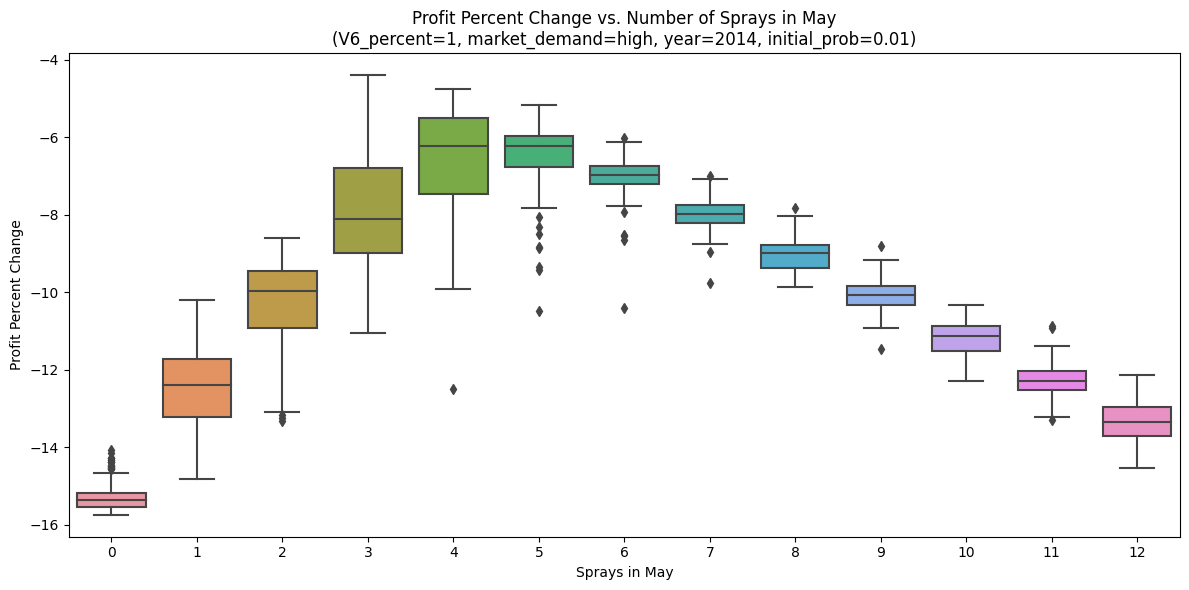

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

year = 2014
market_demand = 'high'
V6_percent = 1
initial_prob = 0.01

# Read the single file
file_name = '../data/processed/simulations/percent_change/profit_percent_change_simulations_power_oct25.csv'
df_profit_all = pd.read_csv(file_name)

# Filter the data based on the specified conditions
df_filtered = df_profit_all[
    (df_profit_all['year'] == year) & 
    (df_profit_all['market_demand'] == market_demand) &
    (df_profit_all['V6_percent'] == V6_percent) &
    (df_profit_all['initial_prob'] == initial_prob)
]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create the box plot
sns.boxplot(x='sprays_in_May', y='profit_percent_change', data=df_filtered, ax=ax)

# Set the order of sprays from 0 to 12
#ax.set_xticklabels(range(13))

# Set labels and title
ax.set_xlabel('Sprays in May')
ax.set_ylabel('Profit Percent Change')
ax.set_title(f'Profit Percent Change vs. Number of Sprays in May\n(V6_percent={V6_percent}, market_demand={market_demand}, year={year}, initial_prob={initial_prob})')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [3]:
!pip install streamlit-plotly-events

   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   ----------------------- ---------------- 8.7/14.8 MB 43.3 MB/s eta 0:00:01
   ---------------------------------------- 14.8/14.8 MB 41.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define parameters
year = 2014
market_demand = 'high'

# Read and filter the data
file_name = '../data/processed/simulations/percent_change/profit_percent_change_simulations_power_oct25.csv'
df_profit_all = pd.read_csv(file_name)
df_profit_all = df_profit_all[
    (df_profit_all['year'] == year) & 
    (df_profit_all['market_demand'] == market_demand)
]

# Convert 'decile' to string type for consistent labeling
df_profit_all['decile'] = df_profit_all['decile'].astype(str)

# Rename 'V6_percent' to 'X% V6'
df_profit_all['V6_percent_label'] = (df_profit_all['V6_percent'] * 100).astype(int).astype(str) + '% V6'

# Rename 'initial_prob' to 'init_prob = XXXX'
df_profit_all['initial_prob_label'] = 'init_prob = ' + df_profit_all['initial_prob'].astype(str)

# Get sorted unique V6_percent and initial_prob values
unique_v6_percent = sorted(df_profit_all['V6_percent'].unique())
unique_v6_labels = [f"{int(v6 * 100)}% V6" for v6 in unique_v6_percent]

unique_init_prob = sorted(df_profit_all['initial_prob'].unique())
unique_init_prob_labels = [f"init_prob = {prob}" for prob in unique_init_prob]

# Define the grid size based on unique V6_percent and initial_prob
n_rows = len(unique_v6_percent)       # Number of unique V6_percent labels
n_cols = len(unique_init_prob)        # Number of unique initial_prob labels

# Get unique combinations sorted by V6_percent ascendingly and initial_prob ascendingly
# **Change Made:** Included 'initial_prob' in unique_combinations to prevent KeyError
unique_combinations = df_profit_all[['V6_percent', 'V6_percent_label', 'initial_prob', 'initial_prob_label']].drop_duplicates()
unique_combinations = unique_combinations.sort_values(['V6_percent', 'initial_prob_label'], ascending=[True, True])

# Number of unique combinations
num_plots = unique_combinations.shape[0]

# Create subplot titles as empty strings
subplot_titles = [''] * (n_rows * n_cols)

# Create the figure with subplots
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=subplot_titles,  # Removed subplot titles
    horizontal_spacing=0.02,  # Minimal horizontal space between plots
    vertical_spacing=0.02,    # Minimal vertical space between plots
    shared_xaxes=True,        # Share x-axes to minimize space
    shared_yaxes=True,        # Share y-axes to minimize space
    specs=[[{'type': 'heatmap'} for _ in range(n_cols)] for _ in range(n_rows)]
)

# Determine global color scale limits
v_min = df_profit_all['profit_percent_change'].min()
v_max = df_profit_all['profit_percent_change'].max()

# Add heatmaps to subplots
for _, row_data in unique_combinations.iterrows():
    v6_label = row_data['V6_percent_label']
    init_prob_label = row_data['initial_prob_label']
    v6_value = row_data['V6_percent']  # Numerical value for correct sorting

    # Filter the dataframe for the current combination
    df_filtered = df_profit_all[
        (df_profit_all['V6_percent_label'] == v6_label) &
        (df_profit_all['initial_prob_label'] == init_prob_label)
    ]

    # Pivot the data for heatmap
    pivot_profit = df_filtered.pivot_table(
        values='profit_percent_change',
        index='decile',
        columns='sprays_in_May',
        aggfunc="mean"
    ).sort_index(axis=1)

    # Get x and y axes labels
    x_labels = pivot_profit.columns.tolist()
    y_labels = pivot_profit.index.tolist()

    # Determine subplot row and column based on V6_percent and initial_prob
    v6_index = unique_v6_percent.index(v6_value)  # 0-based index
    init_prob_index = unique_init_prob.index(row_data['initial_prob'])  # 0-based index

    row = v6_index + 1    # Plotly rows start at 1
    col = init_prob_index + 1

    # Add heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=pivot_profit.values,
            x=x_labels,
            y=y_labels,
            colorscale='Viridis',
            zmin=v_min,
            zmax=v_max,
            coloraxis='coloraxis',  # Assign to shared coloraxis
            showscale=False,        # Disable individual color scales
            xgap=0,                  # Removed gaps between cells in x-direction
            ygap=0,                  # Removed gaps between cells in y-direction
            hoverongaps=False
        ),
        row=row,
        col=col
    )

# Define Dracula color palette
dracula_bg = '#282a36'          # Background
dracula_font = '#f8f8f2'        # Default font color

# Update layout for Dracula theme and define shared coloraxis
fig.update_layout(
    template=None,  # Remove any existing template
    plot_bgcolor=dracula_bg,
    paper_bgcolor=dracula_bg,
    font=dict(
        color=dracula_font,
        size=10
    ),
    title=dict(
        text=f'Figure 1: Relative Change in Profit given {market_demand} Market Demand in {year}',
        font=dict(
            color=dracula_font,
            size=18
        ),
        x=0.45,  # Centered title
        y=0.96,
        xanchor='center',
        yanchor='top'
    ),
    margin=dict(l=80, r=180, t=80, b=80),  # Increased right margin to accommodate colorbar and bottom margin for x-axis title
    coloraxis=dict(
        colorscale='Viridis',
        cmin=v_min,
        cmax=v_max,
        colorbar=dict(
            title='Profit % Change',
            titleside='right',
            tickfont=dict(size=10),
            len=1.05,             # Increased height of colorbar
            y=0.5,                # Center vertically
            x=1.08,               # Moved colorbar further to the right
            thickness=10          # Reduced width of colorbar
        )
    )
)

# Add column labels (initial_prob) at the top of each column
for idx, init_prob_label in enumerate(unique_init_prob_labels):
    # Calculate the x position: center of the subplot column
    x_pos = (idx + 1 - 0.5) / n_cols  # Centered above each column

    # Add annotation
    fig.add_annotation(
        dict(
            text=init_prob_label,
            x=x_pos,
            y=1.07,  # Increased y to add more spacing
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=12,
                color=dracula_font
            ),
            align='center'
        )
    )

# Add row labels (% V6) at the right of each row
for idx, v6_label in enumerate(unique_v6_labels):
    # Calculate the y position: center of the subplot row
    y_pos = 1 - ((idx + 1 - 0.5) / n_rows)

    # Add annotation with vertical rotation
    fig.add_annotation(
        dict(
            text=v6_label,
            x=1.08,  # Moved further to the right to prevent overlapping
            y=y_pos,
            textangle=0,  # Rotated vertically
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=8,
                color=dracula_font
            ),
            align='center'
        )
    )

# Add shared x-axis title
fig.add_annotation(
    dict(
        text="Number of Sprays in May",
        x=0.5,
        y=-0.15,  # Adjusted y to position below the heatmaps
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=14,
            color=dracula_font
        ),
        align='center'
    )
)

# Add shared y-axis title
fig.add_annotation(
    dict(
        text="Percentile of Dispersal-Centrality",
        x=-0.08,  # Adjusted x to position to the left of the heatmaps
        y=0.5,
        textangle=-90,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=14,
            color=dracula_font
        ),
        align='center'
    )
)

fig.update_traces(
    hovertemplate=
    'Sprays in May: %{x}<br>' +
    'Percentile: %{y}<br>' +
    'Profit % Change: %{z:.2f}%<extra></extra>'
)


# Show the figure
fig.show()


In [166]:
import numpy as np

# Load parameters for Figure 1
theta_may_jun_fig1 = np.load('../reports/parameters/theta_may-jun_oct12.npy', allow_pickle=True)
theta_jun_jul_fig1 = np.load('../reports/parameters/theta_jun-jul_power.npy', allow_pickle=True)

# Load parameters for Figure 2
theta_may_jun_fig2 = np.load('../reports/parameters/theta_may-jun.npy', allow_pickle=True)
theta_jun_jul_fig2 = np.load('../reports/parameters/theta_jun-jul_power.npy', allow_pickle=True)

# Define parameter names corresponding to the theta array
param_names = [
    '$\\beta_1$', '$\\beta_2$', '$\\gamma_1$', '$\\gamma_2$',
    '$\\alpha_1$', '$\\alpha_2$', '$\\delta_1$', '$\\delta_2$',
    '$\\eta_{11}$', '$\\eta_{12}$', '$\\eta_{21}$', '$\\eta_{22}$'
]

# Function to format parameters into LaTeX table rows
def format_parameters(param_names, params_fig1, params_fig2):
    rows = ""
    for name, val1, val2 in zip(param_names, params_fig1.flatten(), params_fig2.flatten()):
        rows += f"    & {name} & {val1:.2f} & {val2:.2f} \\\\\n"
    return rows

# Format May-June parameters
may_jun_rows = format_parameters(param_names, theta_may_jun_fig1, theta_may_jun_fig2)

# Format June-July parameters
jun_jul_rows = format_parameters(param_names, theta_jun_jul_fig1, theta_jun_jul_fig2)

# Construct the LaTeX table
latex_table = f"""
\\begin{{table}}[ht]
\\centering
\\caption{{Parameter estimates for epidemic model}}
\\label{{tab:parameter_estimates}}
\\small
\\begin{{tabular}}{{llcc}}
\\toprule
\\multicolumn{{2}}{{l}}{{Parameter}} & Figure 1 & Figure 2 \\\\
\\midrule
\\multicolumn{{4}}{{l}}{{\\textbf{{Epidemic Model}}}} \\\\
\\multicolumn{{4}}{{l}}{{May-June}} \\\\
{may_jun_rows}
\\multicolumn{{4}}{{l}}{{June-July}} \\\\
{jun_jul_rows}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""

# Print the LaTeX table
print(latex_table)



\begin{table}[ht]
\centering
\caption{Parameter estimates for epidemic model}
\label{tab:parameter_estimates}
\small
\begin{tabular}{llcc}
\toprule
\multicolumn{2}{l}{Parameter} & Figure 1 & Figure 2 \\
\midrule
\multicolumn{4}{l}{\textbf{Epidemic Model}} \\
\multicolumn{4}{l}{May-June} \\
    & $\beta_1$ & -2.06 & -1.69 \\
    & $\beta_2$ & -3.86 & -3.58 \\
    & $\gamma_1$ & 2057.59 & 1868.42 \\
    & $\gamma_2$ & 101.65 & 137.41 \\
    & $\alpha_1$ & 34300.78 & 34494.92 \\
    & $\alpha_2$ & 14568.66 & 14874.06 \\
    & $\delta_1$ & 0.71 & 115.70 \\
    & $\delta_2$ & 21.57 & 82.41 \\
    & $\eta_{11}$ & 3.51 & 72.06 \\
    & $\eta_{12}$ & 1.10 & 140.76 \\
    & $\eta_{21}$ & 2.90 & 117.99 \\
    & $\eta_{22}$ & 4.51 & 80.19 \\

\multicolumn{4}{l}{June-July} \\
    & $\beta_1$ & -2.79 & -2.79 \\
    & $\beta_2$ & -3.88 & -3.88 \\
    & $\gamma_1$ & 2.94 & 2.94 \\
    & $\gamma_2$ & 8.14 & 8.14 \\
    & $\alpha_1$ & 1398.29 & 1398.29 \\
    & $\alpha_2$ & 118.64 & 118.64 \\
    & $\

In [168]:
import numpy as np
from tabulate import tabulate

# Load parameters for Figure 1
theta_may_jun_fig1 = np.load('../reports/parameters/theta_may-jun_oct12.npy', allow_pickle=True)
theta_jun_jul_fig1 = np.load('../reports/parameters/theta_jun-jul_power.npy', allow_pickle=True)

# Load parameters for Figure 2
theta_may_jun_fig2 = np.load('../reports/parameters/theta_may-jun.npy', allow_pickle=True)
theta_jun_jul_fig2 = np.load('../reports/parameters/theta_jun-jul_power.npy', allow_pickle=True)

# Define parameter names corresponding to the theta array
param_names = [
    '$\\beta_1$', '$\\beta_2$', '$\\gamma_1$', '$\\gamma_2$',
    '$\\alpha_1$', '$\\alpha_2$', '$\\delta_1$', '$\\delta_2$',
    '$\\eta_{11}$', '$\\eta_{12}$', '$\\eta_{21}$', '$\\eta_{22}$'
]

# Function to round parameters to two decimal places and convert to list
def process_parameters(theta):
    return [round(val[0], 2) for val in theta]

# Process parameters for Figure 1
params_fig1_may_jun = process_parameters(theta_may_jun_fig1)
params_fig1_jun_jul = process_parameters(theta_jun_jul_fig1)

# Process parameters for Figure 2
params_fig2_may_jun = process_parameters(theta_may_jun_fig2)
params_fig2_jun_jul = process_parameters(theta_jun_jul_fig2)

# Function to create table rows for a given period
def create_table_rows(param_names, params_fig1, params_fig2):
    rows = []
    for name, val1, val2 in zip(param_names, params_fig1, params_fig2):
        rows.append([name, val1, val2])
    return rows

# Create rows for May-June and June-July
rows_may_jun = create_table_rows(param_names, params_fig1_may_jun, params_fig2_may_jun)
rows_jun_jul = create_table_rows(param_names, params_fig1_jun_jul, params_fig2_jun_jul)

# Combine all rows with period headers
table_data = []

# Header
table_data.append(["Parameter", "Figure 1", "Figure 2"])

# May-June Section
table_data.append(["\n**Epidemic Model: May-June**", "", ""])
for row in rows_may_jun:
    table_data.append(row)

# June-July Section
table_data.append(["\n**Epidemic Model: June-July**", "", ""])
for row in rows_jun_jul:
    table_data.append(row)

# Print the table using tabulate
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid", stralign="center"))


╒═══════════════════════════════╤════════════╤════════════╕
│           Parameter           │  Figure 1  │  Figure 2  │
╞═══════════════════════════════╪════════════╪════════════╡
│ **Epidemic Model: May-June**  │            │            │
├───────────────────────────────┼────────────┼────────────┤
│           $\beta_1$           │   -2.06    │   -1.69    │
├───────────────────────────────┼────────────┼────────────┤
│           $\beta_2$           │   -3.86    │   -3.58    │
├───────────────────────────────┼────────────┼────────────┤
│          $\gamma_1$           │  2057.59   │  1868.42   │
├───────────────────────────────┼────────────┼────────────┤
│          $\gamma_2$           │   101.65   │   137.41   │
├───────────────────────────────┼────────────┼────────────┤
│          $\alpha_1$           │  34300.78  │  34494.92  │
├───────────────────────────────┼────────────┼────────────┤
│          $\alpha_2$           │  14568.66  │  14874.06  │
├───────────────────────────────┼───────

In [5]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define parameters
year = 2014
market_demand = 'high'

# Read and filter the data
file_name = '../data/processed/simulations/percent_change/profit_percent_change_simulations_power_oct30.csv'
df_profit_all = pd.read_csv(file_name)
df_profit_all = df_profit_all[
    (df_profit_all['year'] == year) & 
    (df_profit_all['market_demand'] == market_demand)
]

# Convert 'decile' to string type for consistent labeling
df_profit_all['decile'] = df_profit_all['decile'].astype(str)

# Rename 'V6_percent' to 'X% V6'
df_profit_all['V6_percent_label'] = (df_profit_all['V6_percent'] * 100).astype(int).astype(str) + '% V6'

# Rename 'initial_prob' to 'init_prob = XXXX'
df_profit_all['initial_prob_label'] = 'init_prob = ' + df_profit_all['initial_prob'].astype(str)

# Get sorted unique V6_percent and initial_prob values
unique_v6_percent = sorted(df_profit_all['V6_percent'].unique())
unique_v6_labels = [f"{int(v6 * 100)}% V6" for v6 in unique_v6_percent]

unique_init_prob = sorted(df_profit_all['initial_prob'].unique())
unique_init_prob_labels = [f"init_prob = {prob}" for prob in unique_init_prob]

# Define the grid size based on unique V6_percent and initial_prob
n_rows = len(unique_v6_percent)       # Number of unique V6_percent labels
n_cols = len(unique_init_prob)        # Number of unique initial_prob labels

# Get unique combinations sorted by V6_percent ascendingly and initial_prob ascendingly
# **Change Made:** Included 'initial_prob' in unique_combinations to prevent KeyError
unique_combinations = df_profit_all[['V6_percent', 'V6_percent_label', 'initial_prob', 'initial_prob_label']].drop_duplicates()
unique_combinations = unique_combinations.sort_values(['V6_percent', 'initial_prob_label'], ascending=[True, True])

# Number of unique combinations
num_plots = unique_combinations.shape[0]

# Create subplot titles as empty strings
subplot_titles = [''] * (n_rows * n_cols)

# Create the figure with subplots
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=subplot_titles,  # Removed subplot titles
    horizontal_spacing=0.02,  # Minimal horizontal space between plots
    vertical_spacing=0.02,    # Minimal vertical space between plots
    shared_xaxes=True,        # Share x-axes to minimize space
    shared_yaxes=True,        # Share y-axes to minimize space
    specs=[[{'type': 'heatmap'} for _ in range(n_cols)] for _ in range(n_rows)]
)

# Determine global color scale limits
v_min = df_profit_all['profit_percent_change'].min()
v_max = df_profit_all['profit_percent_change'].max()

# Add heatmaps to subplots
for _, row_data in unique_combinations.iterrows():
    v6_label = row_data['V6_percent_label']
    init_prob_label = row_data['initial_prob_label']
    v6_value = row_data['V6_percent']  # Numerical value for correct sorting

    # Filter the dataframe for the current combination
    df_filtered = df_profit_all[
        (df_profit_all['V6_percent_label'] == v6_label) &
        (df_profit_all['initial_prob_label'] == init_prob_label)
    ]

    # Pivot the data for heatmap
    pivot_profit = df_filtered.pivot_table(
        values='profit_percent_change',
        index='decile',
        columns='sprays_in_May',
        aggfunc="mean"
    ).sort_index(axis=1)

    # Get x and y axes labels
    x_labels = pivot_profit.columns.tolist()
    y_labels = pivot_profit.index.tolist()

    # Determine subplot row and column based on V6_percent and initial_prob
    v6_index = unique_v6_percent.index(v6_value)  # 0-based index
    init_prob_index = unique_init_prob.index(row_data['initial_prob'])  # 0-based index

    row = v6_index + 1    # Plotly rows start at 1
    col = init_prob_index + 1

    # Add heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=pivot_profit.values,
            x=x_labels,
            y=y_labels,
            colorscale='Viridis',
            zmin=v_min,
            zmax=v_max,
            coloraxis='coloraxis',  # Assign to shared coloraxis
            showscale=False,        # Disable individual color scales
            xgap=0,                  # Removed gaps between cells in x-direction
            ygap=0,                  # Removed gaps between cells in y-direction
            hoverongaps=False
        ),
        row=row,
        col=col
    )

# Define Dracula color palette
dracula_bg = '#282a36'          # Background
dracula_font = '#f8f8f2'        # Default font color

# Update layout for Dracula theme and define shared coloraxis
fig.update_layout(
    template=None,  # Remove any existing template
    plot_bgcolor=dracula_bg,
    paper_bgcolor=dracula_bg,
    font=dict(
        color=dracula_font,
        size=10
    ),
    title=dict(
        text=f'Figure 1: Relative Change in Profit given {market_demand} Market Demand in {year}',
        font=dict(
            color=dracula_font,
            size=18
        ),
        x=0.45,  # Centered title
        y=0.96,
        xanchor='center',
        yanchor='top'
    ),
    margin=dict(l=80, r=180, t=80, b=80),  # Increased right margin to accommodate colorbar and bottom margin for x-axis title
    coloraxis=dict(
        colorscale='Viridis',
        cmin=v_min,
        cmax=v_max,
        colorbar=dict(
            title='Profit % Change',
            titleside='right',
            tickfont=dict(size=10),
            len=1.05,             # Increased height of colorbar
            y=0.5,                # Center vertically
            x=1.08,               # Moved colorbar further to the right
            thickness=10          # Reduced width of colorbar
        )
    )
)

# Add column labels (initial_prob) at the top of each column
for idx, init_prob_label in enumerate(unique_init_prob_labels):
    # Calculate the x position: center of the subplot column
    x_pos = (idx + 1 - 0.5) / n_cols  # Centered above each column

    # Add annotation
    fig.add_annotation(
        dict(
            text=init_prob_label,
            x=x_pos,
            y=1.07,  # Increased y to add more spacing
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=12,
                color=dracula_font
            ),
            align='center'
        )
    )

# Add row labels (% V6) at the right of each row
for idx, v6_label in enumerate(unique_v6_labels):
    # Calculate the y position: center of the subplot row
    y_pos = 1 - ((idx + 1 - 0.5) / n_rows)

    # Add annotation with vertical rotation
    fig.add_annotation(
        dict(
            text=v6_label,
            x=1.08,  # Moved further to the right to prevent overlapping
            y=y_pos,
            textangle=0,  # Rotated vertically
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(
                size=8,
                color=dracula_font
            ),
            align='center'
        )
    )

# Add shared x-axis title
fig.add_annotation(
    dict(
        text="Number of Sprays in May",
        x=0.5,
        y=-0.15,  # Adjusted y to position below the heatmaps
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=14,
            color=dracula_font
        ),
        align='center'
    )
)

# Add shared y-axis title
fig.add_annotation(
    dict(
        text="Percentile of Dispersal-Centrality",
        x=-0.08,  # Adjusted x to position to the left of the heatmaps
        y=0.5,
        textangle=-90,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(
            size=14,
            color=dracula_font
        ),
        align='center'
    )
)

fig.update_traces(
    hovertemplate=
    'Sprays in May: %{x}<br>' +
    'Percentile: %{y}<br>' +
    'Profit % Change: %{z:.2f}%<extra></extra>'
)


# Show the figure
fig.show()
